**画像分類の畳み込みニューラルネットワーク**

tf.keras.Sequentialモデルで画像分類器を構築

tf.keras.preprocessing.image.imageDataGeneratorでデータをロード

tf.keras.preprocessing.image.imageDataGeneratorクラスを使用してデータ入力パイプラインを構築する

Overfittingをどうやって識別して回避するか。
→データ増強とドロップアウトを活用する

**機械学習のワークフロー**

1.データを調べて理解する

2.入力パイプラインを構築する

3.モデルを構築する

4.モデルを訓練する

5.モデルをテストする

6.モデルを改良してプロセスを繰り返す

In [8]:
#パッケージをインポート
from __future__ import absolute_import, division, print_function, unicode_literals

In [9]:
import tensorflow as tf

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
import os
import numpy as np
import matplotlib.pyplot as plt


In [54]:
#データのロード
#KaggleのDogs vs Catsのデータセットを使用

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
 
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
 
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [55]:
#訓練と検証セットのための正しいファイルパスに変数を割り当てる
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [56]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [57]:
#訓練と検証ディレクトリに幾つの猫と犬の画像があるか見てみる
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))
 
num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))
 
total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [58]:
#出力
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)
 
print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [59]:
#データ処理の前処理とネットワークの訓練の際に使用する変数
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

画像の読み込み

RGBコンテンツごとに適当なグリッド形式に変換

浮動少数点tensorに変換

tenforと0と255の間の値から0と1の間の値にリスケール　#ニューラルネットワークは小さい入値力を処理することを好むため


In [60]:
#ImageDataGeneratorクラスで処理
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [61]:
#2つのクラスに1,000枚の画像がある
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [62]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')


Found 1000 images belonging to 2 classes.


In [63]:
#訓練画像の可視化
sample_training_images, _ = next(train_data_gen)

In [64]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

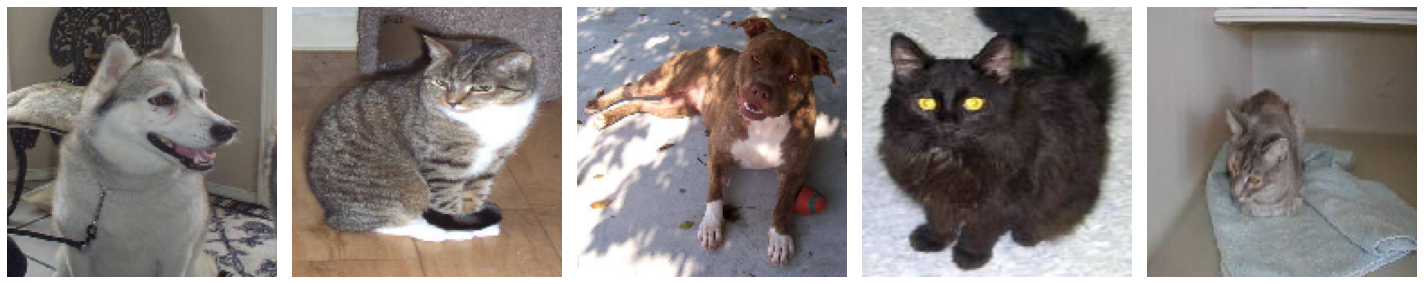

In [65]:
#表示
plotImages(sample_training_images[:5])

**モデルを作成する**

max pool層を伴う3つの畳み込みブロックからなっている。

max pool層の上には512ユニットを持つ完全結合層があり、これはrelu活性化関数により活性化される。

モデルはsigmoid活性化関数による二値分類に基づいてクラス確率を出力する。

In [66]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

**モデルをコンパイルする**

ADAM optimizerと二値交差エントロピー損失関数を選択

In [67]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

**モデル要約**

In [68]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 20736)            

**モデルの訓練**

ネットワークを訓練するためにImageDataGeneratorクラスのfit_generatorメソッドを使用する

In [69]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
15/15 [==============================] - 52s 3s/step - loss: 1.0186 - accuracy: 0.4716 - val_loss: 0.6873 - val_accuracy: 0.4967
Epoch 2/15
15/15 [==============================] - 50s 3s/step - loss: 0.6837 - accuracy: 0.5360 - val_loss: 0.6731 - val_accuracy: 0.5826
Epoch 3/15
15/15 [==============================] - 50s 3s/step - loss: 0.6547 - accuracy: 0.5963 - val_loss: 0.6311 - val_accuracy: 0.6429
Epoch 4/15
15/15 [==============================] - 50s 3s/step - loss: 0.6035 - accuracy: 0.6761 - val_loss: 0.6116 - val_accuracy: 0.6562
Epoch 5/15
15/15 [==============================] - 50s 3s/step - loss: 0.5705 - accuracy: 0.7110 - val_loss: 0.5942 - val_accuracy: 0.6920
Epoch 6/15
15/15 [==============================] - 50s 3s/step - loss: 0.5293 - accuracy: 0.7458 - val_loss: 0.5807 - val_accuracy: 0.6975
Epoch 7/15
15/15 [==============================] - 51s 3s/step - loss: 0.4941 - accuracy: 0.7455 - val_loss: 0.5812 - val_accuracy: 0.7098
Epoch 8/15
15/15 [==

**訓練結果を可視化する**

ネットワーク訓練後、結果を可視化する

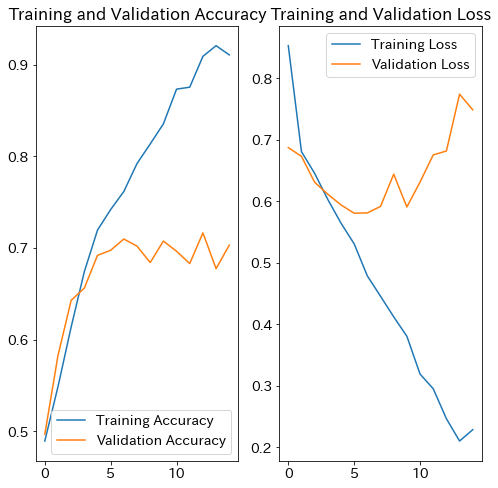

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
 
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs_range = range(epochs)
 
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
 
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

検証データの正解率(Validation Accuracy)は70%

訓練サンプル数が少ない時、モデルは時々ノイズや訓練サンプルの望まれていない学習をします。(overfitting)

Overfitting対策

データ増強、Dropout

In [71]:
#データを増やす
#水平反転を適用する
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 2000 images belonging to 2 classes.


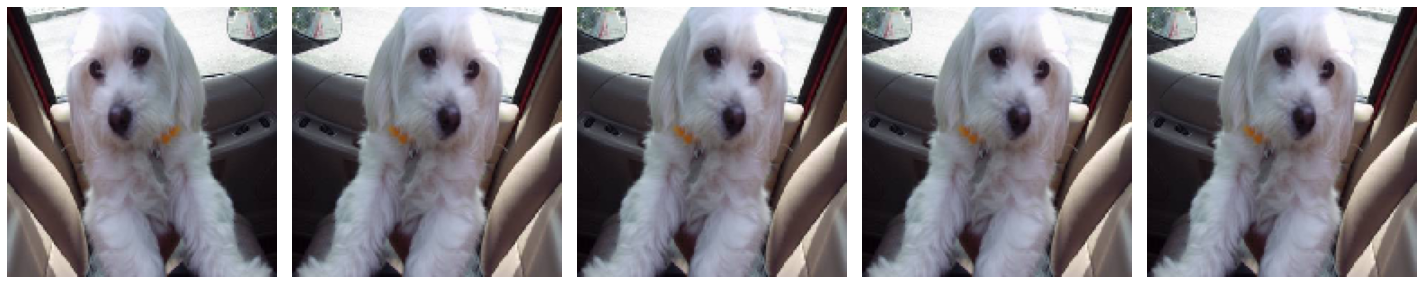

In [72]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

In [73]:
#画像の回転
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))
 
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


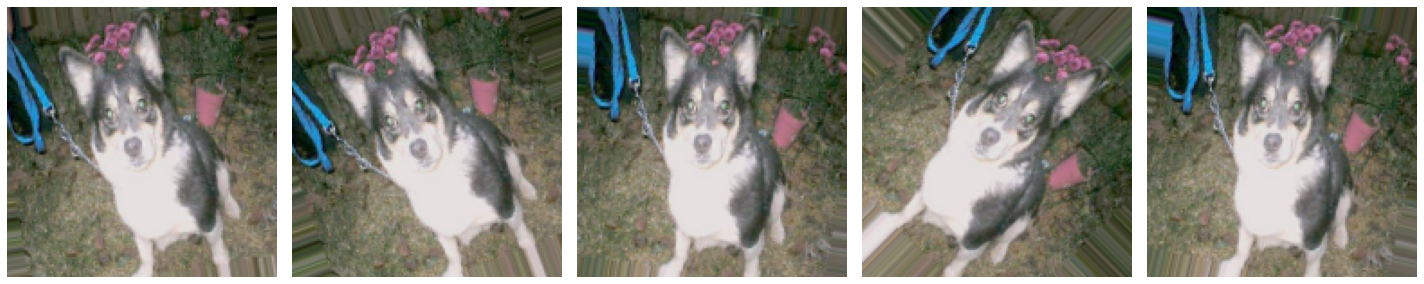

In [74]:
plotImages(augmented_images)

In [75]:
#ズーム増強を適用する
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))
 
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


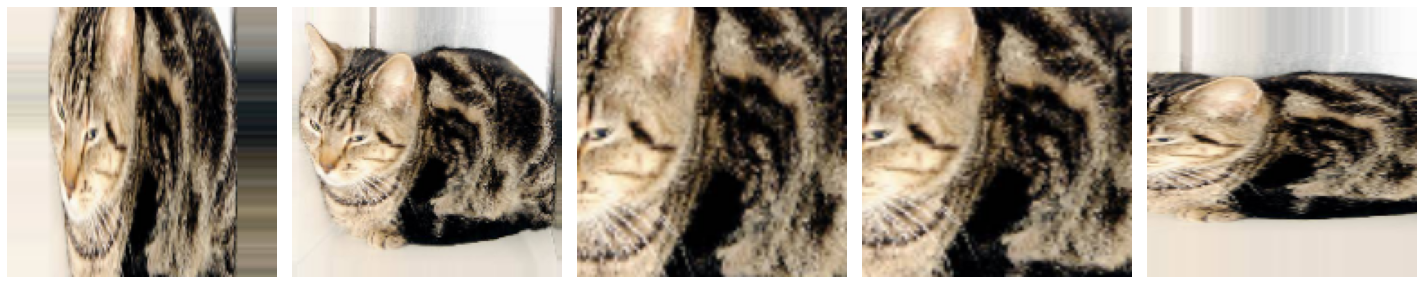

In [76]:
plotImages(augmented_images)

In [77]:
#増強策全てを適用
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [78]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


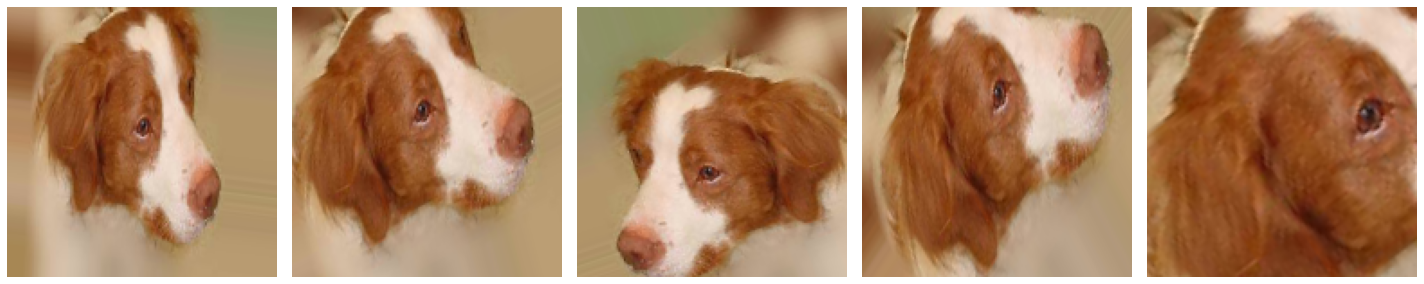

In [79]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [80]:
#検証データgeneratorを作成する
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


In [81]:
#Dropoutで新しいネットワークを作成する
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu',
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [82]:
#モデルをコンパイルする
model_new.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
 
model_new.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 18, 18, 64)       

In [83]:
#モデルを訓練する
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
15/15 [==============================] - 63s 4s/step - loss: 1.5053 - accuracy: 0.4703 - val_loss: 0.6940 - val_accuracy: 0.4978
Epoch 2/15
15/15 [==============================] - 62s 4s/step - loss: 0.6932 - accuracy: 0.5193 - val_loss: 0.6894 - val_accuracy: 0.5134
Epoch 3/15
15/15 [==============================] - 61s 4s/step - loss: 0.6933 - accuracy: 0.5142 - val_loss: 0.6913 - val_accuracy: 0.5558
Epoch 4/15
15/15 [==============================] - 61s 4s/step - loss: 0.6902 - accuracy: 0.5540 - val_loss: 0.6735 - val_accuracy: 0.6083
Epoch 5/15
15/15 [==============================] - 61s 4s/step - loss: 0.6742 - accuracy: 0.5793 - val_loss: 0.6400 - val_accuracy: 0.6239
Epoch 6/15
15/15 [==============================] - 62s 4s/step - loss: 0.6603 - accuracy: 0.5935 - val_loss: 0.6397 - val_accuracy: 0.6127
Epoch 7/15
15/15 [==============================] - 62s 4s/step - loss: 0.6631 - accuracy: 0.5812 - val_loss: 0.6437 - val_accuracy: 0.6272
Epoch 8/15
15/15 [==

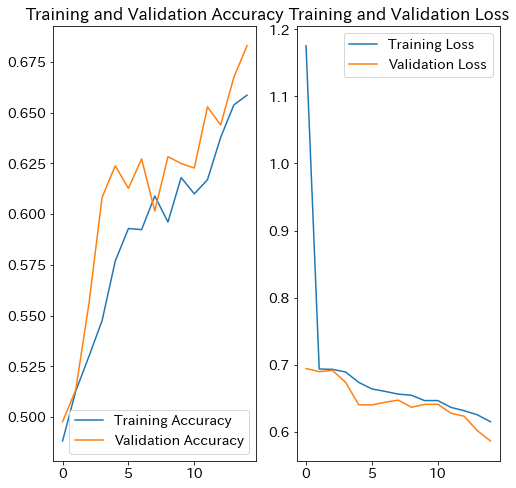

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
 
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs_range = range(epochs)
 
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
 
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()